# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s5e3/train.csv'
    test_path = '/kaggle/input/playground-series-s5e3/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s5e3/sample_submission.csv'
    
    original_path = "/kaggle/input/hongkongrainfall/hongkong.csv"
    original_path_2 = "/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv"
    
    target = 'rainfall'
    n_folds = 10
    seed = 2100
    time_limit = 3600 * 11

    pipeline = 1

# Loading data and predefining folds

In [3]:
def get_data(pipeline):
    train = pd.read_csv(CFG.train_path, index_col="id")
    test = pd.read_csv(CFG.test_path, index_col="id")

    test.winddirection = test.winddirection.fillna(test.winddirection.median())
    
    if pipeline == 1:
        return train, test, None
    
    original = pd.read_csv(CFG.original_path, encoding="gbk")
    original["date"] = pd.to_datetime(original[["year", "month", "day"]])
    original = original.drop(["year", "month", "day", "low visibility hour", "radiation", "evaporation"], axis=1)
    original["day"] = original.date.dt.dayofyear
    original = original.drop("date", axis=1)
    original.rainfall = original.rainfall.apply(lambda x: 1 if str(x).replace('.', '', 1).isdigit() else x)
    original.rainfall = original.rainfall.replace({'微量': 1, '-': 0}).astype(int)
    original.sunshine = original.sunshine.replace('-', 0).astype(float)
    original.windspeed = original.windspeed.fillna(original.windspeed.mean())
    for col in original.columns:
        original[col] = original[col].astype(train[col].dtype)
        
    if pipeline == 2:
        return train, test, original
        
    original_2 = pd.read_csv(CFG.original_path_2)
    original_2.columns = original_2.columns.str.replace(" ", "")
    original_2[CFG.target] = original_2[CFG.target].map({"yes": 1, "no": 0})
    original_2.winddirection = original_2.winddirection.fillna(original_2.winddirection.mean())
    original_2.windspeed = original_2.windspeed.fillna(original_2.windspeed.mean())
    original_2.day = original_2.index + 1
    for col in original_2.columns:
        original_2[col] = original_2[col].astype(train[col].dtype)
        
    if pipeline == 3:
        return train, test, original_2
        
    original_combined = pd.concat([original, original_2], axis=0).reset_index(drop=True)
    original_combined = original_combined.drop_duplicates().reset_index(drop=True)

    return train, test, original_combined

In [4]:
train, test, original = get_data(CFG.pipeline)

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    path='/AutoGluonModels',
    problem_type='binary',
    eval_metric='roc_auc',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

In [7]:
if original is None:
    predictor.fit(
        train_data=train,
        time_limit=CFG.time_limit,
        presets='best_quality'
    )
else:
    predictor.fit_pseudolabel(
        pseudo_data=original,
        train_data=train,
        time_limit=CFG.time_limit,
        presets='best_quality'
    )

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.19 GB / 31.35 GB (96.3%)
Disk Space Avail:   1892.13 GB / 8062.39 GB (23.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stac

(autoscaler +2m36s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +2m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=4300) No improvement since epoch 9: early stopping
(_dystack pid=166) 	0.8882	 = Validation score   (roc_auc)
(_dystack pid=166) 	32.28s	 = Training   runtime
(_dystack pid=166) 	0.16s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_BAG_L1 ... Training model for up to 6414.10s of the 9714.39s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +3m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8885	 = Validation score   (roc_auc)
(_dystack pid=166) 	10.09s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_BAG_L1 ... Training model for up to 6400.57s of the 9700.86s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +3m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=166) 	42.72s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 6354.66s of the 9654.95s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +4m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8664	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.29s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 6333.13s of the 9633.42s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.8975	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.17s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r79_BAG_L1 ... Training model for up to 6315.73s of the 9616.02s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +4m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=166) 	41.59s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r131_BAG_L1 ... Training model for up to 6271.12s of the 9571.40s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +5m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8869	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.94s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 6251.79s of the 9552.08s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=6525) No improvement since epoch 11: early stopping


(autoscaler +6m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=6712) No improvement since epoch 13: early stopping [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=6897) No improvement since epoch 14: early stopping [repeated 4x across cluster]
(_dystack pid=166) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=166) 	41.55s	 = Training   runtime
(_dystack pid=166) 	0.18s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 6206.99s of the 9507.28s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +6m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8934	 = Validation score   (roc_auc)
(_dystack pid=166) 	41.11s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r96_BAG_L1 ... Training model for up to 6162.43s of the 9462.72s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=6927) No improvement since epoch 15: early stopping


(autoscaler +7m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=7385) [1000]	valid_set's binary_logloss: 0.303317
(_ray_fit pid=7517) [1000]	valid_set's binary_logloss: 0.346226 [repeated 8x across cluster]
(_ray_fit pid=7646) [1000]	valid_set's binary_logloss: 0.290323
(_ray_fit pid=7649) [1000]	valid_set's binary_logloss: 0.320026


(_dystack pid=166) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.89s	 = Training   runtime
(_dystack pid=166) 	0.25s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 6143.33s of the 9443.62s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +7m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=166) 	40.42s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 6099.72s of the 9400.01s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.11%)


(autoscaler +8m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8885	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.66s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r42_BAG_L1 ... Training model for up to 6083.82s of the 9384.10s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8856	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.54s	 = Training   runtime
(_dystack pid=166) 	1.08s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r137_BAG_L1 ... Training model for up to 6066.80s of the 9367.09s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8974	 = Validation sco

(autoscaler +9m17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=9277) No improvement since epoch 2: early stopping


(autoscaler +9m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=9644) No improvement since epoch 2: early stopping
(_dystack pid=166) 	0.8982	 = Validation score   (roc_auc)
(_dystack pid=166) 	74.4s	 = Training   runtime
(_dystack pid=166) 	0.41s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r13_BAG_L1 ... Training model for up to 5971.89s of the 9272.18s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +10m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=166) 	31.41s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r195_BAG_L1 ... Training model for up to 5937.30s of the 9237.59s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +11m7s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8804	 = Validation score   (roc_auc)
(_dystack pid=166) 	21.18s	 = Training   runtime
(_dystack pid=166) 	0.94s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r188_BAG_L1 ... Training model for up to 5912.99s of the 9213.27s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=166) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.48s	 = Training   runtime
(_dystack pid=166) 	0.09s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r145_BAG_L1 ... Training model for up to 5895.45s of the 9195.74s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +11m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=10935) No improvement since epoch 9: early stopping
(_ray_fit pid=11118) No improvement since epoch 7: early stopping
(_ray_fit pid=11120) No improvement since epoch 9: early stopping
(_ray_fit pid=11305) No improvement since epoch 10: early stopping
(_dystack pid=166) 	0.8918	 = Validation score   (roc_auc)
(_dystack pid=166) 	41.28s	 = Training   runtime
(_dystack pid=166) 	0.19s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r89_BAG_L1 ... Training model for up to 5850.96s of the 9151.25s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +12m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	8.74s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r30_BAG_L1 ... Training model for up to 5838.90s of the 9139.19s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +13m7s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=166) 	65.05s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r130_BAG_L1 ... Training model for up to 5770.85s of the 9071.14s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +13m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8945	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.05s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r86_BAG_L1 ... Training model for up to 5753.59s of the 9053.88s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +14m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=166) 	36.28s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r50_BAG_L1 ... Training model for up to 5714.19s of the 9014.48s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.95s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r11_BAG_L1 ... Training model for up to 5697.11s of the 8997.40s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +15m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=13183) No improvement since epoch 6: early stopping
(_ray_fit pid=13401) No improvement since epoch 9: early stopping [repeated 3x across cluster]
(_ray_fit pid=13555) No improvement since epoch 10: early stopping
(_dystack pid=166) 	0.9003	 = Validation score   (roc_auc)
(_dystack pid=166) 	47.2s	 = Training   runtime
(_dystack pid=166) 	0.25s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r194_BAG_L1 ... Training model for up to 5646.78s of the 8947.07s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +15m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8865	 = Validation score   (roc_auc)
(_dystack pid=166) 	9.44s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r172_BAG_L1 ... Training model for up to 5634.13s of the 8934.42s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.65s	 = Training   runtime
(_dystack pid=166) 	0.96s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r69_BAG_L1 ... Training model for up to 5618.29s of the 8918.58s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +16m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.37s	 = Training   runtime
(_dystack pid=166) 	0.01s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r103_BAG_L1 ... Training model for up to 5601.93s of the 8902.22s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=14837) No improvement since epoch 16: early stopping
(_ray_fit pid=15022) No improvement since epoch 14: early stopping [repeated 2x across cluster]
(_ray_fit pid=15210) No improvement since epoch 20: early stopping [repeated 4x across cluster]
(_dystack pid=166) 	0.8954	 = Validation score   (roc_auc)
(_dystack pid=166) 	34.0s	 = Training   runtime
(_dystack pid=166) 	0.18s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r14_BAG_L1 ... Training model for up to 5564.88s of the 8865.17s of remaining time.
(_dystac

(autoscaler +17m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8975	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.56s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r161_BAG_L1 ... Training model for up to 5530.49s of the 8830.77s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +17m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8902	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.77s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r143_BAG_L1 ... Training model for up to 5506.99s of the 8807.28s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +18m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8924	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.9s	 = Training   runtime
(_dystack pid=166) 	0.16s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r70_BAG_L1 ... Training model for up to 5476.75s of the 8777.04s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +19m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8953	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.13s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r156_BAG_L1 ... Training model for up to 5448.25s of the 8748.54s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=16864) No improvement since epoch 3: early stopping


(autoscaler +19m38s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=16865) No improvement since epoch 16: early stopping
(_ray_fit pid=16867) No improvement since epoch 23: early stopping
(_ray_fit pid=17047) No improvement since epoch 3: early stopping
(_ray_fit pid=17079) No improvement since epoch 3: early stopping
(_ray_fit pid=17126) No improvement since epoch 8: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.8932	 = Validation score   (roc_auc)
(_dystack pid=166) 	82.0s	 = Training   runtime
(_dystack pid=166) 	0.32s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r196_BAG_L1 ... Training model for up to 5362.92s of the 8663.21s of remaining time.
(_ray_fit pid=17234) No improvement since epoch 4: early stopping
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +20m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=17329) [1000]	valid_set's binary_logloss: 0.303465
(_ray_fit pid=17332) [1000]	valid_set's binary_logloss: 0.35315
(_ray_fit pid=17460) [1000]	valid_set's binary_logloss: 0.359795 [repeated 6x across cluster]
(_ray_fit pid=17591) [1000]	valid_set's binary_logloss: 0.294934 [repeated 3x across cluster]


(_dystack pid=166) 	0.897	 = Validation score   (roc_auc)
(_dystack pid=166) 	21.35s	 = Training   runtime
(_dystack pid=166) 	0.54s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 5337.96s of the 8638.25s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +21m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8823	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.95s	 = Training   runtime
(_dystack pid=166) 	1.16s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 5314.55s of the 8614.83s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=166) 	0.8944	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.16s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r95_BAG_L1 ... Training model for up to 5293.26s of the 8593.55s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +21m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=18708) No improvement since epoch 8: early stopping
(_ray_fit pid=18890) No improvement since epoch 10: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=166) 	43.23s	 = Training   runtime
(_dystack pid=166) 	0.23s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r41_BAG_L1 ... Training model for up to 5246.93s of the 8547.21s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +22m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8947	 = Validation score   (roc_auc)
(_dystack pid=166) 	47.12s	 = Training   runtime
(_dystack pid=166) 	0.2s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r98_BAG_L1 ... Training model for up to 5196.67s of the 8496.96s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +23m29s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8912	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.38s	 = Training   runtime
(_dystack pid=166) 	0.18s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r15_BAG_L1 ... Training model for up to 5177.82s of the 8478.11s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8932	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.53s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r158_BAG_L1 ... Training model for up to 5158.96s of the 8459.25s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +24m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +24m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.885	 = Validation score   (roc_auc)
(_dystack pid=166) 	49.09s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r86_BAG_L1 ... Training model for up to 5106.35s of the 8406.64s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +25m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8936	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.24s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r37_BAG_L1 ... Training model for up to 5077.25s of the 8377.54s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +25m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=21152) No improvement since epoch 20: early stopping
(_dystack pid=166) 	0.8934	 = Validation score   (roc_auc)
(_dystack pid=166) 	33.33s	 = Training   runtime
(_dystack pid=166) 	0.21s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r197_BAG_L1 ... Training model for up to 5040.75s of the 8341.04s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8978	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.88s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r49_BAG_L1 ... Training model for up to 5005.95s of the 8306.24s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +26m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8963	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.3s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r49_BAG_L1 ... Training model for up to 4988.23s of the 8288.52s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.886	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.2s	 = Training   runtime
(_dystack pid=166) 	1.08s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r143_BAG_L1 ... Training model for up to 4968.58s of the 8268.87s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +27m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8851	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.8s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r127_BAG_L1 ... Training model for up to 4947.32s of the 8247.61s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +27m50s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8878	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.91s	 = Training   runtime
(_dystack pid=166) 	1.08s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r134_BAG_L1 ... Training model for up to 4920.89s of the 8221.18s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +28m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=23275) No improvement since epoch 18: early stopping
(_ray_fit pid=23277) No improvement since epoch 23: early stopping [repeated 2x across cluster]


(autoscaler +29m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +29m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=23525) No improvement since epoch 13: early stopping
(_ray_fit pid=23459) No improvement since epoch 25: early stopping
(_ray_fit pid=23585) No improvement since epoch 22: early stopping
(_ray_fit pid=23678) No improvement since epoch 25: early stopping
(_dystack pid=166) 	0.8951	 = Validation score   (roc_auc)
(_dystack pid=166) 	143.83s	 = Training   runtime
(_dystack pid=166) 	0.41s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r34_BAG_L1 ... Training model for up to 4773.77s of the 8074.06s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +30m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8925	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.75s	 = Training   runtime
(_dystack pid=166) 	0.91s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r94_BAG_L1 ... Training model for up to 4755.62s of the 8055.91s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(_ray_fit pid=24210) [1000]	valid_set's binary_logloss: 0.294527 [repeated 5x across cluster]


(_dystack pid=166) 	0.8978	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.65s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r143_BAG_L1 ... Training model for up to 4737.70s of the 8037.98s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +31m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +31m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8929	 = Validation score   (roc_auc)
(_dystack pid=166) 	52.72s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r128_BAG_L1 ... Training model for up to 4681.60s of the 7981.88s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +32m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8928	 = Validation score   (roc_auc)
(_dystack pid=166) 	38.38s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r111_BAG_L1 ... Training model for up to 4639.32s of the 7939.61s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +32m50s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +33m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8957	 = Validation score   (roc_auc)
(_dystack pid=166) 	67.86s	 = Training   runtime
(_dystack pid=166) 	0.49s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r31_BAG_L1 ... Training model for up to 4568.20s of the 7868.49s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +34m1s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=166) 	35.42s	 = Training   runtime
(_dystack pid=166) 	0.14s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r4_BAG_L1 ... Training model for up to 4528.98s of the 7829.27s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +34m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8926	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.78s	 = Training   runtime
(_dystack pid=166) 	1.01s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r65_BAG_L1 ... Training model for up to 4511.83s of the 7812.12s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8895	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.08s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r88_BAG_L1 ... Training model for up to 4482.56s of the 7782.85s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +35m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=27064) No improvement since epoch 7: early stopping
(_ray_fit pid=27248) No improvement since epoch 5: early stopping [repeated 4x across cluster]
(_dystack pid=166) 	0.8739	 = Validation score   (roc_auc)
(_dystack pid=166) 	24.78s	 = Training   runtime
(_dystack pid=166) 	0.17s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r30_BAG_L1 ... Training model for up to 4454.56s of the 7754.85s of remaining time.
(_ray_fit pid=27342) No improvement since epoch 5: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(_ray_fit pid=27535) [1000]	valid_set's binary_logloss: 0.296375
(_ray_fit pid=27534) [1000]	valid_set's binary_logloss: 0.304081
(autoscaler +35m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=27799) [1000]	valid_set's binary_logloss: 0.317417


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.41s	 = Training   runtime
(_dystack pid=166) 	0.26s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r49_BAG_L1 ... Training model for up to 4433.90s of the 7734.19s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=166) 	0.8913	 = Validation score   (roc_auc)
(_dystack pid=166) 	10.43s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r5_BAG_L1 ... Training model for up to 4420.33s of the 7720.62s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +36m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.31s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r87_BAG_L1 ... Training model for up to 4403.35s of the 7703.64s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +37m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8969	 = Validation score   (roc_auc)
(_dystack pid=166) 	48.49s	 = Training   runtime
(_dystack pid=166) 	0.14s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r71_BAG_L1 ... Training model for up to 4351.88s of the 7652.17s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +37m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.71s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r143_BAG_L1 ... Training model for up to 4321.81s of the 7622.10s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=166) 	0.8955	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.86s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r178_BAG_L1 ... Training model for up to 4300.19s of the 7600.48s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +38m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8912	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.12s	 = Training   runtime
(_dystack pid=166) 	1.05s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r166_BAG_L1 ... Training model for up to 4280.60s of the 7580.89s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +38m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8824	 = Validation score   (roc_auc)
(_dystack pid=166) 	20.78s	 = Training   runtime
(_dystack pid=166) 	1.03s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r31_BAG_L1 ... Training model for up to 4256.34s of the 7556.63s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.45s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r185_BAG_L1 ... Training model for up to 4241.33s of the 7541.62s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +39m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8924	 = Validation score   (roc_auc)
(_dystack pid=166) 	38.53s	 = Training   runtime
(_dystack pid=166) 	0.17s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r160_BAG_L1 ... Training model for up to 4199.67s of the 7499.96s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +40m7s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.897	 = Validation score   (roc_auc)
(_dystack pid=166) 	36.91s	 = Training   runtime
(_dystack pid=166) 	0.23s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r60_BAG_L1 ... Training model for up to 4159.23s of the 7459.52s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +40m42s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8984	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.78s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r15_BAG_L1 ... Training model for up to 4139.50s of the 7439.79s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +41m17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8847	 = Validation score   (roc_auc)
(_dystack pid=166) 	21.54s	 = Training   runtime
(_dystack pid=166) 	1.05s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r135_BAG_L1 ... Training model for up to 4114.61s of the 7414.90s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.05%)
(_dystack pid=166) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.2s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r22_BAG_L1 ... Training model for up to 4096.15s of the 7396.44s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +41m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8915	 = Validation score   (roc_auc)
(_dystack pid=166) 	9.61s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r69_BAG_L1 ... Training model for up to 4082.48s of the 7382.77s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +42m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8957	 = Validation score   (roc_auc)
(_dystack pid=166) 	35.69s	 = Training   runtime
(_dystack pid=166) 	0.25s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r6_BAG_L1 ... Training model for up to 4043.47s of the 7343.76s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8962	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.3s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r138_BAG_L1 ... Training model for up to 4024.37s of the 7324.66s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +43m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=34179) No improvement since epoch 16: early stopping


(autoscaler +43m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=34394) No improvement since epoch 17: early stopping [repeated 3x across cluster]
(_ray_fit pid=34552) No improvement since epoch 15: early stopping [repeated 4x across cluster]
(_dystack pid=166) 	0.8916	 = Validation score   (roc_auc)
(_dystack pid=166) 	60.45s	 = Training   runtime
(_dystack pid=166) 	0.24s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r121_BAG_L1 ... Training model for up to 3960.52s of the 7260.81s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.05%)


(autoscaler +44m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8893	 = Validation score   (roc_auc)
(_dystack pid=166) 	21.0s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r172_BAG_L1 ... Training model for up to 3936.06s of the 7236.35s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=34981) No improvement since epoch 9: early stopping


(autoscaler +44m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=35163) No improvement since epoch 4: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.8917	 = Validation score   (roc_auc)
(_dystack pid=166) 	28.16s	 = Training   runtime
(_dystack pid=166) 	0.19s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r180_BAG_L1 ... Training model for up to 3904.37s of the 7204.65s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_ray_fit pid=35351) No improvement since epoch 11: early stopping
(_dystack pid=166) 	0.8966	 = Validation score   (roc_auc)
(_dystack pid=166) 	31.42s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r76_BAG_L1 ... Training model for up to 3869.27s of the 7169.55s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 w

(autoscaler +45m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8953	 = Validation score   (roc_auc)
(_dystack pid=166) 	29.56s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r197_BAG_L1 ... Training model for up to 3836.31s of the 7136.60s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +46m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8856	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.64s	 = Training   runtime
(_dystack pid=166) 	1.09s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r121_BAG_L1 ... Training model for up to 3813.80s of the 7114.09s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +46m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.888	 = Validation score   (roc_auc)
(_dystack pid=166) 	50.48s	 = Training   runtime
(_dystack pid=166) 	0.17s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r127_BAG_L1 ... Training model for up to 3760.06s of the 7060.35s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +47m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.35s	 = Training   runtime
(_dystack pid=166) 	0.23s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r16_BAG_L1 ... Training model for up to 3730.86s of the 7031.15s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +47m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8789	 = Validation score   (roc_auc)
(_dystack pid=166) 	28.57s	 = Training   runtime
(_dystack pid=166) 	1.1s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r194_BAG_L1 ... Training model for up to 3698.63s of the 6998.91s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +48m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8934	 = Validation score   (roc_auc)
(_dystack pid=166) 	31.14s	 = Training   runtime
(_dystack pid=166) 	0.21s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r12_BAG_L1 ... Training model for up to 3663.99s of the 6964.28s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +49m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=166) 	21.41s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r135_BAG_L1 ... Training model for up to 3638.87s of the 6939.15s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +49m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8954	 = Validation score   (roc_auc)
(_dystack pid=166) 	49.98s	 = Training   runtime
(_dystack pid=166) 	0.14s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r4_BAG_L1 ... Training model for up to 3585.50s of the 6885.79s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +50m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=39376) No improvement since epoch 17: early stopping
(_ray_fit pid=39562) No improvement since epoch 11: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.8959	 = Validation score   (roc_auc)
(_dystack pid=166) 	31.28s	 = Training   runtime
(_dystack pid=166) 	0.18s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r126_BAG_L1 ... Training model for up to 3550.73s of the 6851.02s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +50m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8901	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.74s	 = Training   runtime
(_dystack pid=166) 	1.08s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r36_BAG_L1 ... Training model for up to 3531.33s of the 6831.62s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +51m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8956	 = Validation score   (roc_auc)
(_dystack pid=166) 	44.94s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r100_BAG_L1 ... Training model for up to 3483.20s of the 6783.49s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +52m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +52m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=40497) No improvement since epoch 9: early stopping
(_ray_fit pid=40494) No improvement since epoch 14: early stopping [repeated 2x across cluster]


(autoscaler +53m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=40742) No improvement since epoch 7: early stopping
(_ray_fit pid=40709) No improvement since epoch 13: early stopping
(_ray_fit pid=40775) No improvement since epoch 10: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.8855	 = Validation score   (roc_auc)
(_dystack pid=166) 	121.6s	 = Training   runtime
(_dystack pid=166) 	0.5s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r163_BAG_L1 ... Training model for up to 3358.21s of the 6658.50s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +54m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.24s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r198_BAG_L1 ... Training model for up to 3340.46s of the 6640.75s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.8966	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.62s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r187_BAG_L1 ... Training model for up to 3320.38s of the 6620.67s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +54m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.89	 = Validation score   (roc_auc)
(_dystack pid=166) 	28.01s	 = Training   runtime
(_dystack pid=166) 	0.18s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r19_BAG_L1 ... Training model for up to 3288.97s of the 6589.26s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +55m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8941	 = Validation score   (roc_auc)
(_dystack pid=166) 	29.37s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r95_BAG_L1 ... Training model for up to 3256.04s of the 6556.33s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +55m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.892	 = Validation score   (roc_auc)
(_dystack pid=166) 	10.41s	 = Training   runtime
(_dystack pid=166) 	0.08s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r34_BAG_L1 ... Training model for up to 3242.22s of the 6542.51s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.11%)
(_dystack pid=166) 	0.8907	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.39s	 = Training   runtime
(_dystack pid=166) 	0.09s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r42_BAG_L1 ... Training model for up to 3227.54s of the 6527.82s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.05%)
(_dystack pid=166) 	0.8972	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.17s	 = Training   runtime
(_dystack pid=166) 	

(autoscaler +56m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8903	 = Validation score   (roc_auc)
(_dystack pid=166) 	41.24s	 = Training   runtime
(_dystack pid=166) 	0.14s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r89_BAG_L1 ... Training model for up to 3164.41s of the 6464.70s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +57m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8935	 = Validation score   (roc_auc)
(_dystack pid=166) 	46.54s	 = Training   runtime
(_dystack pid=166) 	0.17s	 = Validation runtime
(_dystack pid=166) Fitting model: WeightedEnsemble_L2 ... Training model for up to 659.56s of the 6414.89s of remaining time.
(_dystack pid=166) 	Ensemble Weights: {'CatBoost_r50_BAG_L1': 0.4, 'NeuralNetFastAI_r11_BAG_L1': 0.28, 'NeuralNetTorch_r197_BAG_L1': 0.12, 'KNeighborsDist_BAG_L1': 0.04, 'NeuralNetFastAI_r102_BAG_L1': 0.04, 'XGBoost_r89_BAG_L1': 0.04, 'CatBoost_r69_BAG_L1': 0.04, 'NeuralNetTorch_r14_BAG_L1': 0.04}
(_dystack pid=166) 	0.9061	 = Validation score   (roc_auc)
(_dystack pid=166) 	0.22s	 = Training   runtime
(_dystack pid=166) 	0.0s	 = Validation runtime
(_dystack pid=166) Fitting 108 L2 models, fit_strategy="sequential" ...
(_dystack pid=166) Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 6414.65s of the 6414.17s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting

(autoscaler +58m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9033	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.05s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_BAG_L2 ... Training model for up to 6395.97s of the 6395.49s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.09%)
(_dystack pid=166) 	0.8992	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.14s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 6375.39s of the 6374.91s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +58m50s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8974	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.8s	 = Training   runtime
(_dystack pid=166) 	1.01s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 6355.12s of the 6354.64s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.9009	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.6s	 = Training   runtime
(_dystack pid=166) 	1.19s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_BAG_L2 ... Training model for up to 6333.18s of the 6332.71s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)


(autoscaler +59m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9051	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.03s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTreesGini_BAG_L2 ... Training model for up to 6307.12s of the 6306.64s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.45s	 = Training   runtime
(_dystack pid=166) 	1.03s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTreesEntr_BAG_L2 ... Training model for up to 6291.33s of the 6290.86s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.9028	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.25s	 = Training   runtime
(_dystack pid=166) 	1.03s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 6274.67s of the 6274.20s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=47218) No improvement since

(autoscaler +1h40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=47405) No improvement since epoch 7: early stopping
(_ray_fit pid=47401) No improvement since epoch 8: early stopping
(_dystack pid=166) 	0.8965	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.18s	 = Training   runtime
(_dystack pid=166) 	0.22s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_BAG_L2 ... Training model for up to 6241.29s of the 6240.82s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=166) 	0.9002	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.87s	 = Training   runtime
(_dystack pid=166) 	0.09s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_BAG_L2 ... Training model for up to 6225.98s of the 6225.50s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02

(autoscaler +1h1m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=166) 	41.21s	 = Training   runtime
(_dystack pid=166) 	0.34s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 6181.35s of the 6180.87s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h2m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8803	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.62s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r177_BAG_L2 ... Training model for up to 6154.38s of the 6153.90s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)


(autoscaler +1h2m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9034	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.29s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r79_BAG_L2 ... Training model for up to 6128.41s of the 6127.94s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h3m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.906	 = Validation score   (roc_auc)
(_dystack pid=166) 	54.39s	 = Training   runtime
(_dystack pid=166) 	0.34s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r131_BAG_L2 ... Training model for up to 6070.68s of the 6070.21s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.15%)


(autoscaler +1h3m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9011	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.21s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r191_BAG_L2 ... Training model for up to 6048.15s of the 6047.67s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=49812) No improvement since epoch 14: early stopping


(autoscaler +1h4m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=50060) No improvement since epoch 4: early stopping
(_ray_fit pid=50028) No improvement since epoch 13: early stopping
(_ray_fit pid=50184) No improvement since epoch 16: early stopping
(_ray_fit pid=50216) No improvement since epoch 22: early stopping
(_dystack pid=166) 	0.8963	 = Validation score   (roc_auc)
(_dystack pid=166) 	43.79s	 = Training   runtime
(_dystack pid=166) 	0.21s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r9_BAG_L2 ... Training model for up to 6001.13s of the 6000.65s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +1h5m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h5m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9042	 = Validation score   (roc_auc)
(_dystack pid=166) 	93.67s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r96_BAG_L2 ... Training model for up to 5904.07s of the 5903.59s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h6m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=50670) [1000]	valid_set's binary_logloss: 0.272771
(_ray_fit pid=50670) [2000]	valid_set's binary_logloss: 0.272125
(_ray_fit pid=50670) [3000]	valid_set's binary_logloss: 0.270808
(_ray_fit pid=50670) [4000]	valid_set's binary_logloss: 0.270575
(_ray_fit pid=50801) [1000]	valid_set's binary_logloss: 0.336464


(_dystack pid=166) 	0.9044	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.29s	 = Training   runtime
(_dystack pid=166) 	0.25s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 5883.28s of the 5882.80s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h7m16s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=166) 	50.98s	 = Training   runtime
(_dystack pid=166) 	0.35s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 5829.12s of the 5828.65s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.23%)


(autoscaler +1h7m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9021	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.38s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r42_BAG_L2 ... Training model for up to 5806.10s of the 5805.62s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.899	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.38s	 = Training   runtime
(_dystack pid=166) 	1.19s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r137_BAG_L2 ... Training model for up to 5787.34s of the 5786.86s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h8m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9039	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.01s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r102_BAG_L2 ... Training model for up to 5768.10s of the 5767.63s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h9m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h9m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9067	 = Validation score   (roc_auc)
(_dystack pid=166) 	80.08s	 = Training   runtime
(_dystack pid=166) 	0.58s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r13_BAG_L2 ... Training model for up to 5684.75s of the 5684.27s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +1h10m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h10m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9037	 = Validation score   (roc_auc)
(_dystack pid=166) 	66.37s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r195_BAG_L2 ... Training model for up to 5614.94s of the 5614.46s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h11m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.896	 = Validation score   (roc_auc)
(_dystack pid=166) 	37.99s	 = Training   runtime
(_dystack pid=166) 	1.15s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r188_BAG_L2 ... Training model for up to 5573.66s of the 5573.19s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h12m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.73s	 = Training   runtime
(_dystack pid=166) 	0.09s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r145_BAG_L2 ... Training model for up to 5553.84s of the 5553.36s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=54217) No improvement since epoch 9: early stopping


(autoscaler +1h12m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=54405) No improvement since epoch 9: early stopping
(_ray_fit pid=54593) No improvement since epoch 10: early stopping
(_dystack pid=166) 	0.9022	 = Validation score   (roc_auc)
(_dystack pid=166) 	42.31s	 = Training   runtime
(_dystack pid=166) 	0.24s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r89_BAG_L2 ... Training model for up to 5508.18s of the 5507.71s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)


(autoscaler +1h13m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.904	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.33s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_ray_fit pid=54590) No improvement since epoch 10: early stopping
(_dystack pid=166) Fitting model: NeuralNetTorch_r30_BAG_L2 ... Training model for up to 5493.26s of the 5492.79s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h13m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.898	 = Validation score   (roc_auc)
(_dystack pid=166) 	102.92s	 = Training   runtime
(_dystack pid=166) 	0.35s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r130_BAG_L2 ... Training model for up to 5386.96s of the 5386.48s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.23%)


(autoscaler +1h15m17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9015	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.57s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r86_BAG_L2 ... Training model for up to 5368.22s of the 5367.74s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h15m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=166) 	38.91s	 = Training   runtime
(_dystack pid=166) 	0.34s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r50_BAG_L2 ... Training model for up to 5325.99s of the 5325.52s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h16m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9066	 = Validation score   (roc_auc)
(_dystack pid=166) 	21.06s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r11_BAG_L2 ... Training model for up to 5301.35s of the 5300.87s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h17m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=56662) No improvement since epoch 1: early stopping
(_dystack pid=166) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=166) 	48.84s	 = Training   runtime
(_dystack pid=166) 	0.27s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r194_BAG_L2 ... Training model for up to 5249.18s of the 5248.71s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)
(_ray_fit pid=56660) No improvement since epoch 10: early stopping


(autoscaler +1h17m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8986	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.98s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r172_BAG_L2 ... Training model for up to 5233.95s of the 5233.47s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.9017	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.45s	 = Training   runtime
(_dystack pid=166) 	0.97s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r69_BAG_L2 ... Training model for up to 5217.17s of the 5216.69s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +1h18m13s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9041	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.73s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r103_BAG_L2 ... Training model for up to 5195.26s of the 5194.78s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=58131) No improvement since epoch 17: early stopping


(autoscaler +1h18m48s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=58346) No improvement since epoch 13: early stopping [repeated 2x across cluster]
(_ray_fit pid=58503) No improvement since epoch 10: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.8992	 = Validation score   (roc_auc)
(_dystack pid=166) 	35.34s	 = Training   runtime
(_dystack pid=166) 	0.2s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r14_BAG_L2 ... Training model for up to 5156.55s of the 5156.07s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h19m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=166) 	31.7s	 = Training   runtime
(_dystack pid=166) 	0.29s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r161_BAG_L2 ... Training model for up to 5121.08s of the 5120.61s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)
(_ray_fit pid=58501) No improvement since epoch 16: early stopping


(autoscaler +1h19m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.901	 = Validation score   (roc_auc)
(_dystack pid=166) 	24.88s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r143_BAG_L2 ... Training model for up to 5092.55s of the 5092.08s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=166) 	0.8959	 = Validation score   (roc_auc)
(_dystack pid=166) 	27.27s	 = Training   runtime
(_dystack pid=166) 	0.24s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r70_BAG_L2 ... Training model for up to 5061.91s of the 5061.43s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)


(autoscaler +1h20m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9054	 = Validation score   (roc_auc)
(_dystack pid=166) 	46.33s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r156_BAG_L2 ... Training model for up to 5011.85s of the 5011.37s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h21m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=60155) No improvement since epoch 3: early stopping
(_ray_fit pid=60152) No improvement since epoch 23: early stopping
(_ray_fit pid=60153) No improvement since epoch 21: early stopping


(autoscaler +1h22m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=60336) No improvement since epoch 10: early stopping
(_ray_fit pid=60385) No improvement since epoch 5: early stopping
(_ray_fit pid=60554) No improvement since epoch 13: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.8993	 = Validation score   (roc_auc)
(_dystack pid=166) 	82.89s	 = Training   runtime
(_dystack pid=166) 	0.34s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r196_BAG_L2 ... Training model for up to 4925.53s of the 4925.06s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.34%)


(autoscaler +1h22m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=60618) [1000]	valid_set's binary_logloss: 0.351755
(_ray_fit pid=60750) [1000]	valid_set's binary_logloss: 0.337676 [repeated 4x across cluster]
(_ray_fit pid=60882) [1000]	valid_set's binary_logloss: 0.286556
(_ray_fit pid=60884) [1000]	valid_set's binary_logloss: 0.32237


(_dystack pid=166) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.72s	 = Training   runtime
(_dystack pid=166) 	0.42s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r39_BAG_L2 ... Training model for up to 4899.02s of the 4898.54s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h23m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8971	 = Validation score   (roc_auc)
(_dystack pid=166) 	35.89s	 = Training   runtime
(_dystack pid=166) 	1.37s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r167_BAG_L2 ... Training model for up to 4859.52s of the 4859.04s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h24m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9032	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.39s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r95_BAG_L2 ... Training model for up to 4825.87s of the 4825.39s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h24m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=61992) No improvement since epoch 10: early stopping
(_ray_fit pid=62180) No improvement since epoch 9: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.899	 = Validation score   (roc_auc)
(_dystack pid=166) 	43.88s	 = Training   runtime
(_dystack pid=166) 	0.25s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r41_BAG_L2 ... Training model for up to 4778.81s of the 4778.33s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h25m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9063	 = Validation score   (roc_auc)
(_dystack pid=166) 	44.56s	 = Training   runtime
(_dystack pid=166) 	0.34s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r98_BAG_L2 ... Training model for up to 4730.45s of the 4729.98s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +1h26m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9024	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.25s	 = Training   runtime
(_dystack pid=166) 	0.19s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r15_BAG_L2 ... Training model for up to 4704.84s of the 4704.36s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.07%)


(autoscaler +1h26m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9044	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.25s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r158_BAG_L2 ... Training model for up to 4685.45s of the 4684.98s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h27m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8938	 = Validation score   (roc_auc)
(_dystack pid=166) 	110.64s	 = Training   runtime
(_dystack pid=166) 	0.3s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r86_BAG_L2 ... Training model for up to 4571.52s of the 4571.05s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)


(autoscaler +1h28m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h29m29s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9046	 = Validation score   (roc_auc)
(_dystack pid=166) 	56.14s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r37_BAG_L2 ... Training model for up to 4512.12s of the 4511.64s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h30m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=64255) No improvement since epoch 18: early stopping
(_dystack pid=166) 	0.8999	 = Validation score   (roc_auc)
(_dystack pid=166) 	33.18s	 = Training   runtime
(_dystack pid=166) 	0.21s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r197_BAG_L2 ... Training model for up to 4475.64s of the 4475.16s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h30m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9024	 = Validation score   (roc_auc)
(_dystack pid=166) 	28.03s	 = Training   runtime
(_dystack pid=166) 	0.4s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r49_BAG_L2 ... Training model for up to 4444.12s of the 4443.64s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=166) 	0.9067	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.92s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r49_BAG_L2 ... Training model for up to 4424.78s of the 4424.31s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h31m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.35s	 = Training   runtime
(_dystack pid=166) 	1.04s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r143_BAG_L2 ... Training model for up to 4405.93s of the 4405.46s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.44%)


(autoscaler +1h31m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.26s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r127_BAG_L2 ... Training model for up to 4380.44s of the 4379.96s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h32m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8979	 = Validation score   (roc_auc)
(_dystack pid=166) 	40.38s	 = Training   runtime
(_dystack pid=166) 	1.1s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r134_BAG_L2 ... Training model for up to 4336.53s of the 4336.05s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h33m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=66562) No improvement since epoch 11: early stopping


(autoscaler +1h33m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=66561) No improvement since epoch 22: early stopping


(autoscaler +1h34m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=66824) No improvement since epoch 17: early stopping
(_ray_fit pid=66932) No improvement since epoch 25: early stopping
(_dystack pid=166) 	0.9023	 = Validation score   (roc_auc)
(_dystack pid=166) 	149.54s	 = Training   runtime
(_dystack pid=166) 	0.46s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r34_BAG_L2 ... Training model for up to 4183.72s of the 4183.24s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h35m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.96s	 = Training   runtime
(_dystack pid=166) 	1.0s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r94_BAG_L2 ... Training model for up to 4157.25s of the 4156.78s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h35m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=67628) [1000]	valid_set's binary_logloss: 0.33728


(_dystack pid=166) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.51s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r143_BAG_L2 ... Training model for up to 4139.41s of the 4138.94s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h36m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=166) 	95.44s	 = Training   runtime
(_dystack pid=166) 	0.33s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r128_BAG_L2 ... Training model for up to 4040.41s of the 4039.94s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)


(autoscaler +1h37m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h38m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=166) 	91.33s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r111_BAG_L2 ... Training model for up to 3945.70s of the 3945.23s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h39m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h39m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.903	 = Validation score   (roc_auc)
(_dystack pid=166) 	67.86s	 = Training   runtime
(_dystack pid=166) 	0.48s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r31_BAG_L2 ... Training model for up to 3874.57s of the 3874.10s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h40m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8969	 = Validation score   (roc_auc)
(_dystack pid=166) 	43.49s	 = Training   runtime
(_dystack pid=166) 	0.32s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r4_BAG_L2 ... Training model for up to 3827.71s of the 3827.23s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h41m16s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.2s	 = Training   runtime
(_dystack pid=166) 	1.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r65_BAG_L2 ... Training model for up to 3809.96s of the 3809.48s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h41m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8908	 = Validation score   (roc_auc)
(_dystack pid=166) 	27.05s	 = Training   runtime
(_dystack pid=166) 	0.21s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r88_BAG_L2 ... Training model for up to 3779.44s of the 3778.96s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=70363) No improvement since epoch 1: early stopping
(_ray_fit pid=70544) No improvement since epoch 1: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.8662	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.73s	 = Training   runtime
(_dystack pid=166) 	0.19s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r30_BAG_L2 ... Training model for up to 3748.91s of the 3748.44s of remaining time.
(_ray_fit pid=70639) No improvement since epoch 1: early stopping [repeated 2x across cluster]
(_dystack pid=166

(autoscaler +1h42m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=70830) [1000]	valid_set's binary_logloss: 0.267845
(_ray_fit pid=70830) [2000]	valid_set's binary_logloss: 0.264825
(_ray_fit pid=70960) [1000]	valid_set's binary_logloss: 0.335016


(_dystack pid=166) 	0.9027	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.64s	 = Training   runtime
(_dystack pid=166) 	0.23s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r49_BAG_L2 ... Training model for up to 3725.55s of the 3725.07s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)
(_dystack pid=166) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.59s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r5_BAG_L2 ... Training model for up to 3708.63s of the 3708.15s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h43m16s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9035	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.07s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r87_BAG_L2 ... Training model for up to 3689.34s of the 3688.86s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h43m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9012	 = Validation score   (roc_auc)
(_dystack pid=166) 	42.44s	 = Training   runtime
(_dystack pid=166) 	0.32s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r71_BAG_L2 ... Training model for up to 3643.57s of the 3643.09s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h44m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	32.52s	 = Training   runtime
(_dystack pid=166) 	0.32s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r143_BAG_L2 ... Training model for up to 3607.83s of the 3607.36s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h45m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.904	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.34s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r178_BAG_L2 ... Training model for up to 3573.61s of the 3573.13s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h45m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.1s	 = Training   runtime
(_dystack pid=166) 	1.01s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r166_BAG_L2 ... Training model for up to 3554.12s of the 3553.64s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8968	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.12s	 = Training   runtime
(_dystack pid=166) 	1.26s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r31_BAG_L2 ... Training model for up to 3527.57s of the 3527.10s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)


(autoscaler +1h46m17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9027	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.8s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r185_BAG_L2 ... Training model for up to 3509.40s of the 3508.93s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h46m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.901	 = Validation score   (roc_auc)
(_dystack pid=166) 	43.69s	 = Training   runtime
(_dystack pid=166) 	0.35s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r160_BAG_L2 ... Training model for up to 3461.97s of the 3461.50s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h47m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=166) 	36.84s	 = Training   runtime
(_dystack pid=166) 	0.31s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r60_BAG_L2 ... Training model for up to 3421.40s of the 3420.92s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +1h48m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9061	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.21s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r15_BAG_L2 ... Training model for up to 3398.45s of the 3397.98s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h48m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8969	 = Validation score   (roc_auc)
(_dystack pid=166) 	35.69s	 = Training   runtime
(_dystack pid=166) 	1.35s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r135_BAG_L2 ... Training model for up to 3359.40s of the 3358.92s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.51%)


(autoscaler +1h49m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9018	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.45s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r22_BAG_L2 ... Training model for up to 3338.63s of the 3338.15s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=166) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=166) 	10.87s	 = Training   runtime
(_dystack pid=166) 	0.08s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r69_BAG_L2 ... Training model for up to 3324.30s of the 3323.82s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h49m48s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=166) 	35.06s	 = Training   runtime
(_dystack pid=166) 	0.22s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r6_BAG_L2 ... Training model for up to 3285.99s of the 3285.51s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h50m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9062	 = Validation score   (roc_auc)
(_dystack pid=166) 	20.93s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r138_BAG_L2 ... Training model for up to 3261.61s of the 3261.13s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h50m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=77473) No improvement since epoch 10: early stopping
(_ray_fit pid=77474) No improvement since epoch 22: early stopping [repeated 3x across cluster]
(_ray_fit pid=77655) No improvement since epoch 10: early stopping
(_ray_fit pid=77657) No improvement since epoch 8: early stopping
(_ray_fit pid=77748) No improvement since epoch 12: early stopping
(_ray_fit pid=77718) No improvement since epoch 23: early stopping
(_ray_fit pid=77839) No improvement since epoch 11: early stopping
(_ray_fit pid=77871) No improvement since epoch 10: early stopping
(_dystack pid=166) 	0.8948	 = Validation score   (roc_auc)
(_dystack pid=166) 	55.12s	 = Training   runtime
(_dystack pid=166) 	0.28s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r121_BAG_L2 ... Training model for up to 3203.20s of the 3202.72s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.53%

(autoscaler +1h51m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.12s	 = Training   runtime
(_dystack pid=166) 	0.2s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r172_BAG_L2 ... Training model for up to 3173.47s of the 3172.99s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h52m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=78459) No improvement since epoch 11: early stopping
(_ray_fit pid=78647) No improvement since epoch 11: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.8982	 = Validation score   (roc_auc)
(_dystack pid=166) 	28.25s	 = Training   runtime
(_dystack pid=166) 	0.29s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r180_BAG_L2 ... Training model for up to 3141.90s of the 3141.43s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h52m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h53m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9068	 = Validation score   (roc_auc)
(_dystack pid=166) 	64.77s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r76_BAG_L2 ... Training model for up to 3073.69s of the 3073.22s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h54m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=166) 	29.98s	 = Training   runtime
(_dystack pid=166) 	0.33s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r197_BAG_L2 ... Training model for up to 3040.51s of the 3040.04s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h54m38s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8983	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.06s	 = Training   runtime
(_dystack pid=166) 	1.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r121_BAG_L2 ... Training model for up to 3017.62s of the 3017.14s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h55m13s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=166) 	83.07s	 = Training   runtime
(_dystack pid=166) 	0.34s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r127_BAG_L2 ... Training model for up to 2931.39s of the 2930.92s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h56m13s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8929	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.29s	 = Training   runtime
(_dystack pid=166) 	0.18s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r16_BAG_L2 ... Training model for up to 2902.69s of the 2902.22s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h56m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8946	 = Validation score   (roc_auc)
(_dystack pid=166) 	50.57s	 = Training   runtime
(_dystack pid=166) 	1.23s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r194_BAG_L2 ... Training model for up to 2848.52s of the 2848.04s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h57m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8942	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.51s	 = Training   runtime
(_dystack pid=166) 	0.28s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r12_BAG_L2 ... Training model for up to 2814.79s of the 2814.31s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(autoscaler +1h58m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9046	 = Validation score   (roc_auc)
(_dystack pid=166) 	42.53s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r135_BAG_L2 ... Training model for up to 2768.67s of the 2768.19s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h58m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h59m29s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9063	 = Validation score   (roc_auc)
(_dystack pid=166) 	63.1s	 = Training   runtime
(_dystack pid=166) 	0.35s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r4_BAG_L2 ... Training model for up to 2702.28s of the 2701.80s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=82481) No improvement since epoch 18: early stopping
(_ray_fit pid=82665) No improvement since epoch 13: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.9017	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.66s	 = Training   runtime
(_dystack pid=166) 	0.19s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r126_BAG_L2 ... Training model for up to 2668.33s of the 2667.85s of remaining time.
(_ray_fit pid=82667) No improvement since epoch 18: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +2h39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.79s	 = Training   runtime
(_dystack pid=166) 	1.01s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r36_BAG_L2 ... Training model for up to 2648.91s of the 2648.43s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h1m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9003	 = Validation score   (roc_auc)
(_dystack pid=166) 	47.63s	 = Training   runtime
(_dystack pid=166) 	0.3s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r100_BAG_L2 ... Training model for up to 2598.01s of the 2597.53s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h1m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +2h2m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=83774) No improvement since epoch 11: early stopping


(autoscaler +2h2m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=83957) No improvement since epoch 11: early stopping
(_ray_fit pid=83989) No improvement since epoch 9: early stopping
(_ray_fit pid=84176) No improvement since epoch 9: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.8927	 = Validation score   (roc_auc)
(_dystack pid=166) 	119.29s	 = Training   runtime
(_dystack pid=166) 	0.42s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r163_BAG_L2 ... Training model for up to 2474.80s of the 2474.33s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +2h3m50s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9042	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.07s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r198_BAG_L2 ... Training model for up to 2454.45s of the 2453.97s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)


(autoscaler +2h4m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9045	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.16s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r187_BAG_L2 ... Training model for up to 2425.94s of the 2425.47s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=166) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.81s	 = Training   runtime
(_dystack pid=166) 	0.22s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r19_BAG_L2 ... Training model for up to 2395.95s of the 2395.48s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h5m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=166) 	29.62s	 = Training   runtime
(_dystack pid=166) 	0.3s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r95_BAG_L2 ... Training model for up to 2362.81s of the 2362.34s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)


(autoscaler +2h5m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=166) 	10.6s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r34_BAG_L2 ... Training model for up to 2348.85s of the 2348.37s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.23%)
(_dystack pid=166) 	0.9015	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.0s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r42_BAG_L2 ... Training model for up to 2331.58s of the 2331.11s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.49%)


(autoscaler +2h6m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.95s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r1_BAG_L2 ... Training model for up to 2314.39s of the 2313.92s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h6m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.906	 = Validation score   (roc_auc)
(_dystack pid=166) 	48.56s	 = Training   runtime
(_dystack pid=166) 	0.32s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r89_BAG_L2 ... Training model for up to 2262.56s of the 2262.08s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h7m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9011	 = Validation score   (roc_auc)
(_dystack pid=166) 	45.46s	 = Training   runtime
(_dystack pid=166) 	0.29s	 = Validation runtime
(_dystack pid=166) Fitting model: WeightedEnsemble_L3 ... Training model for up to 641.46s of the 2213.14s of remaining time.
(_dystack pid=166) 	Ensemble Weights: {'XGBoost_r89_BAG_L2': 0.208, 'CatBoost_r180_BAG_L2': 0.208, 'NeuralNetTorch_r135_BAG_L2': 0.208, 'NeuralNetFastAI_r102_BAG_L2': 0.167, 'NeuralNetTorch_r41_BAG_L2': 0.125, 'NeuralNetFastAI_r111_BAG_L2': 0.083}
(_dystack pid=166) 	0.9129	 = Validation score   (roc_auc)
(_dystack pid=166) 	0.23s	 = Training   runtime
(_dystack pid=166) 	0.0s	 = Validation runtime
(_dystack pid=166) AutoGluon training complete, total runtime = 7683.12s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 25.7 rows/s (195 batch size)
(_dystack pid=166) TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/AutoGluonModels/ds_sub_fit/sub_fit_ho")
(_dystack p

In [8]:
def get_ensemble_weights(predictor):
    selected_models = []
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
            selected_models.extend(values["children_info"][list(children_info.keys())[0]]["model_weights"].keys())
            selected_models.append(model_name)
    return ensemble_weights, list(set(selected_models))

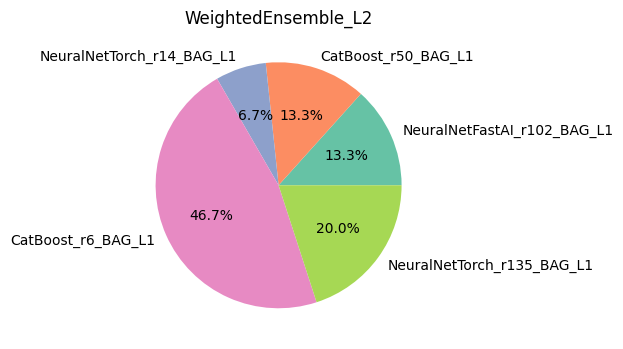

In [9]:
ensemble_weights, selected_models = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [10]:
predictor.leaderboard(silent=True)[predictor.leaderboard(silent=True).model.isin(selected_models)].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.902516,roc_auc,0.681894,195.247421,0.000776,0.217047,2,True,111
1,CatBoost_r6_BAG_L1,0.899394,roc_auc,0.026242,13.633388,0.026242,13.633388,1,True,85
2,CatBoost_r50_BAG_L1,0.899127,roc_auc,0.029441,14.982305,0.029441,14.982305,1,True,33
13,NeuralNetFastAI_r102_BAG_L1,0.895684,roc_auc,0.363908,83.334416,0.363908,83.334416,1,True,24
17,NeuralNetTorch_r135_BAG_L1,0.895062,roc_auc,0.143142,46.515099,0.143142,46.515099,1,True,97
20,NeuralNetTorch_r14_BAG_L1,0.894833,roc_auc,0.118385,36.565166,0.118385,36.565166,1,True,39


# Collecting and saving OOF files

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = 'oof_pred_probs' if type == 'oof' else 'test_pred_probs'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_pred_probs', exist_ok=True)
os.makedirs('test_pred_probs', exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_test_pred_probs = test_pred_probs[model].values[:, 1]
    
    cv_score = roc_auc_score(train[CFG.target], model_oof_pred_probs)
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', False)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', True)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.

# Visualizing the results

In [14]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = roc_auc_score(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

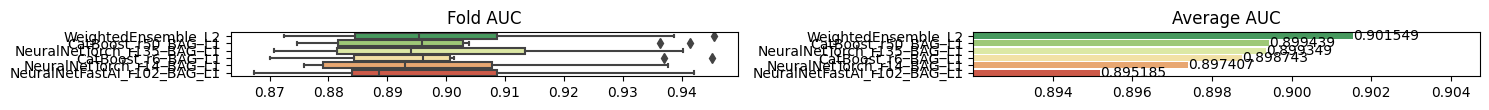

In [15]:
scores = pd.DataFrame(scores)[selected_models]
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.2))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()